In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df=pd.read_csv('baby-names-national.csv')
df.head(5)

,name,sex,count,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880


In [3]:
grouped= df.groupby(['sex'])['count'].sum()

In [4]:
grouped


sex
F    177378491
M    181102218
Name: count, dtype: int64

In [5]:
bnames_count= df.pivot_table('count', index='year', columns='sex', aggfunc=sum)

In [6]:
bnames_count

sex,F,M
year,,
1880,90994,110490
1881,91953,100738
1882,107847,113686
1883,112319,104625
1884,129019,114442
...,...,...
2016,1768360,1893917
2017,1722140,1846154
2018,1695654,1810309


<AxesSubplot:title={'center':'total counts by sex and year'}, xlabel='year'>

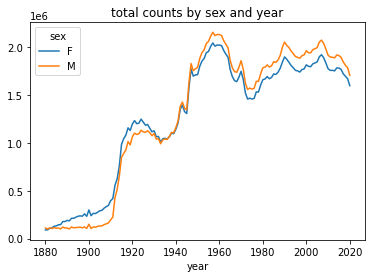

In [7]:
bnames_count.plot(title='total counts by sex and year')

Next is identifying the fraction of babies given each name relative to the total number of births . A prop value of 0.5 would indicate that half of the babies were given a certain name. Thus, we group the data by year and sex, then we add  the new column to each group.

In [8]:
def add_prop(group):
    group['prop']= group['count']/group['count'].sum()
    return group

babynms=df.groupby(['year', 'sex']).apply(add_prop)

In [9]:
babynms.head(11)

,name,sex,count,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015539
8,Bertha,F,1320,1880,0.014506
9,Sarah,F,1288,1880,0.014155


Now this is done we are going to extract a subset of the data to facilitate further analysis

In [10]:
def get_top1000(group):
    return group.sort_values('count', ascending=False)[:1000]

top1000_names=babynms.groupby(['year', 'sex']).apply(get_top1000)

In [11]:
top1000_names=top1000_names.reset_index(drop=True)

In [12]:
top1000_names.head()

,name,sex,count,year,prop
0,Mary,F,7065,1880,0.077642
1,Anna,F,2604,1880,0.028617
2,Emma,F,2003,1880,0.022012
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


ANALYZING NAMING TRENDS

In [13]:
boys=top1000_names[top1000_names['sex']=='M']

In [14]:
boys.head()

,name,sex,count,year,prop
942,John,M,9655,1880,0.087383
943,William,M,9532,1880,0.086270
944,James,M,5927,1880,0.053643
945,Charles,M,5348,1880,0.048403
946,George,M,5126,1880,0.046393


In [15]:
girls=top1000_names[top1000_names['sex']=='F']

In [16]:
total_births=top1000_names.pivot_table('count', index='year', columns='name', aggfunc=sum)

In [17]:
subset=total_births[['John','William','Mary', 'Anna']]

array([<AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>,
       <AxesSubplot:xlabel='year'>, <AxesSubplot:xlabel='year'>],
      dtype=object)

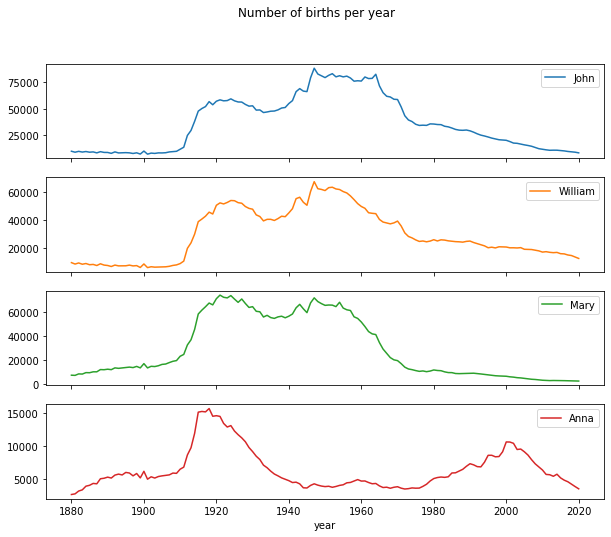

In [18]:
subset.plot(subplots=True, title='Number of births per year', figsize=(10,8))

Measuring the increase in the name diversity

One reason for the decrease in plots is that fewer parents are choosing common names for their children. This hypothesis can be explored and confirmed in the data. One measure is the proportion of births represented by the top 1000 most popular names, which I aggregate and plot by year and sex

In [19]:
table= top1000_names.pivot_table('prop', index='year',columns='sex', aggfunc=sum)

<AxesSubplot:title={'center':'Sum of table1000.prop by year and sex'}, xlabel='year'>

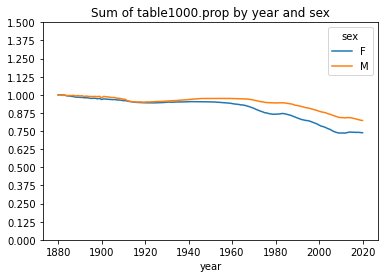

In [20]:
table.plot(title='Sum of table1000.prop by year and sex',yticks=np.linspace(0,1.5,13))

From the graph above it is obvious that there appears to be increasing in name diversity (total proportion in the top one thousand )
Also we can now find the number of distinct names, taken in order of popularity from higherst to lowest, in the top 50 percent of births. This number is trickier to compute. Let's consider just the boy nanes from 2020

In [21]:
df_boys=boys[boys['year']==2020]

In [22]:
df_boys.head()

,name,sex,count,year,prop
280876,Liam,M,19659,2020,0.011521
280877,Noah,M,18252,2020,0.010696
280878,Oliver,M,14147,2020,0.008290
280879,Elijah,M,13034,2020,0.007638
280880,William,M,12541,2020,0.007349


After sorting prop in descendiing order, we want to know how many of the most popular names it takes to reach 50% .Taking the cumulative sum,cumsum, of the prop and then calling the method searchsorted  returns the position in the cumulative sum at which 0.5 would need to be inserted to keep it in sorted order:

In [23]:
prop_cumsum=df_boys['prop'].sort_values(ascending= False).cumsum()

In [24]:
prop_cumsum[:11]

280876    0.011521
280877    0.022217
280878    0.030507
280879    0.038145
280880    0.045495
280881    0.052673
280882    0.059785
280883    0.066396
280884    0.072670
280885    0.078618
280886    0.084495
Name: prop, dtype: float64

In [25]:
prop_cumsum.searchsorted(0.5)+1

163

We can now apply this operation to each year/sex combination, groupby those fields, and apply a function returning the count for each grouop:
    

In [27]:
def get_quantile_count(group, q=0.5):
    sorted=group.sort_values('prop', ascending=False)
    return sorted.prop.cumsum().searchsorted(q)+1

dist_names= top1000_names.groupby(['year','sex']).apply(get_quantile_count)
dist_names=dist_names.unstack()

In [28]:
dist_names.head()

sex,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


<AxesSubplot:title={'center':'Number of popular names in the top 50%'}, xlabel='year'>

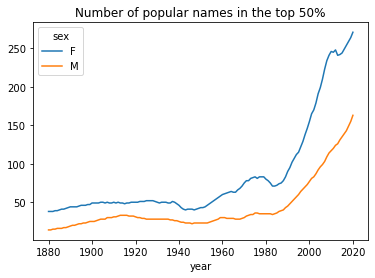

In [29]:
dist_names.plot(title='Number of popular names in the top 50%')

"Last letter" revolution

In [30]:
def get_lastletter(x):
    return x[-1]

last_letters= df['name'].map(get_lastletter)

In [31]:
last_letters.name= 'last_letter'


In [32]:
table=df.pivot_table('count', index=last_letters, columns=['sex','year'], aggfunc=sum)

In [33]:
subtable=table.reindex(columns=[2000,2010,2020], level='year')

In [34]:
subtable.head(5)

sex                 F                             M                    
year             2000      2010      2020      2000      2010      2020
last_letter                                                            
a            676150.0  677100.0  610878.0   40864.0   28882.0   33463.0
b               372.0     455.0     530.0   50933.0   39294.0   17947.0
c               525.0     957.0     884.0   27027.0   23357.0   16541.0
d              4383.0    2645.0    3773.0   64355.0   44851.0   38591.0
e            318492.0  316878.0  283355.0  148954.0  130307.0  115556.0

In [35]:
letter_prop= subtable/subtable.sum()

In [36]:
letter_prop

sex                 F                             M                    
year             2000      2010      2020      2000      2010      2020
last_letter                                                            
a            0.372423  0.381253  0.382077  0.020812  0.015065  0.019610
b            0.000205  0.000256  0.000331  0.025940  0.020496  0.010517
c            0.000289  0.000539  0.000553  0.013765  0.012183  0.009693
d            0.002414  0.001489  0.002360  0.032776  0.023394  0.022615
e            0.175425  0.178424  0.177226  0.075863  0.067968  0.067718
f            0.000015  0.000055  0.000101  0.000877  0.001206  0.001569
g            0.000322  0.000377  0.000439  0.001223  0.001407  0.002667
h            0.064642  0.075989  0.069198  0.043353  0.051822  0.054508
i            0.023461  0.031697  0.047678  0.009355  0.022670  0.032438
j            0.000054  0.000093  0.000087  0.000469  0.000772  0.000849
k            0.000319  0.000355  0.000362  0.022681  0.018532  0.020408
l            0.031196  0.026390  0.021209  0.079176  0.070457  0.065354
m            0.002107  0.002599  0.004158  0.021124  0.024706  0.032865
n            0.136865  0.140053  0.113937  0.313020  0.362410  0.314847
o            0.001213  0.001247  0.002166  0.041044  0.042563  0.060136
p            0.000022  0.000020  0.000095  0.001810  0.001269  0.001512
q                 NaN  0.000030  0.000043  0.000357  0.000180  0.000192
r            0.027969  0.018047  0.033274  0.086377  0.087393  0.095193
s            0.017958  0.013337  0.011769  0.074373  0.065158  0.077964
t            0.005395  0.007838  0.014742  0.025825  0.022861  0.032832
u            0.000263  0.000416  0.000667  0.000915  0.001228  0.003375
v            0.000023  0.000117  0.000290  0.000501  0.001451  0.001678
w            0.000468  0.001190  0.004168  0.028409  0.016183  0.009996
x            0.000406  0.000730  0.002093  0.005444  0.008599  0.011669
y            0.135699  0.116760  0.110323  0.073006  0.058201  0.047783
z            0.000845  0.000700  0.000655  0.001504  0.001829  0.002011

<AxesSubplot:title={'center':'Female'}, xlabel='last_letter'>

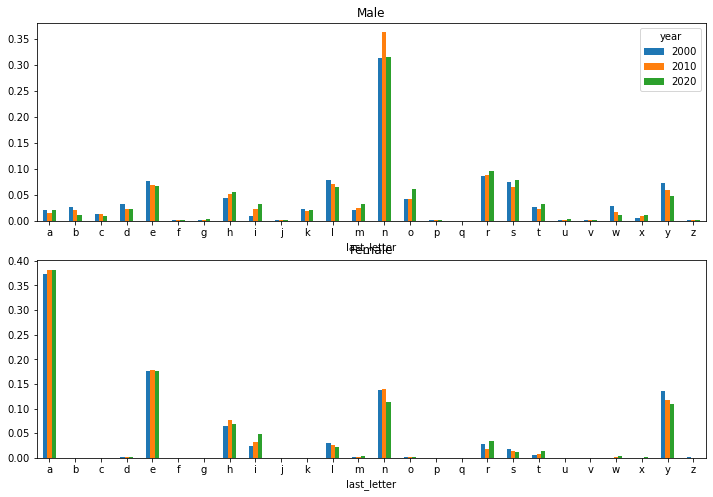

In [41]:
fig,axes=plt.subplots(2,1, figsize=(12,8))
letter_prop['M'].plot(kind='bar',rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female', legend=False)

As you can see, boy names ending in n have experienced significant growth since the 2000s. Going back to the full table created before. I again normalize by year and sex and select a subset of letters for the boy names, finally transposing to make each column a time series:

In [42]:
ltter_prop= table/table.sum()

In [43]:
dny_nms=ltter_prop.loc[['d','n','y'],'M'].T

In [44]:
dny_nms.head()

last_letter,d,n,y
year,,,
1880,0.083057,0.153217,0.075763
1881,0.083246,0.153219,0.077458
1882,0.085332,0.149561,0.077538
1883,0.084053,0.151656,0.079149
1884,0.086122,0.149927,0.080408


<AxesSubplot:xlabel='year'>

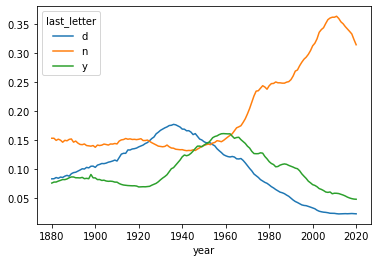

In [45]:
dny_nms.plot()

Boy names that became girl names (and vice versa)

We can look ar names that were more popular with one gender earlier. In the sample but have become preffered as a name for the other gender over time. One example is the nem Lesley or Leslie. Going back to the top1000_names DataFrame, I compute a list of names occuring in the dataset starting with 'Lesl':

In [46]:
all_names=pd.Series(top1000_names['name'].unique())

In [47]:
lesley_like= all_names[all_names.str.contains('Lesl')]
lesley_like

632     Leslie
2293    Lesley
4265    Leslee
4733     Lesli
6109     Lesly
dtype: object

In [48]:
filtered= top1000_names[top1000_names['name'].isin(lesley_like)]

In [49]:
filtered.groupby('name')['count'].sum()

name
Leslee      1082
Lesley     35037
Lesli        929
Leslie    379236
Lesly      11433
Name: count, dtype: int64

In [50]:
#NExt let's aggregate by sex and year, and normalize within year:

In [51]:
table=filtered.pivot_table('count', index='year', columns='sex', aggfunc='sum')

In [54]:
table= table.div(table.sum(axis='columns'), axis='index')

In [55]:
table.head()

sex,F,M
year,,
1880,0.091954,0.908046
1881,0.106796,0.893204
1882,0.065693,0.934307
1883,0.053030,0.946970
1884,0.107143,0.892857


<AxesSubplot:xlabel='year'>

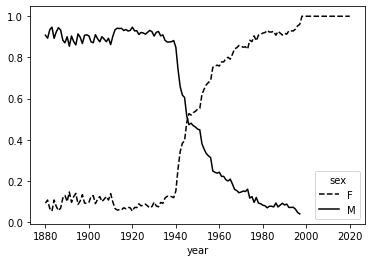

In [57]:
table.plot(style={'M':'k-', 'F':'k--'})